# Gaussian based statistics for kitchen appliances and refrigerator


In [1]:
!python --version
!pip install boto3

Python 3.10.12


## Imports and drive mount

In [114]:
import pandas as pd
# import plotly.express as px
import matplotlib.pyplot as plt
import os
import numpy as np
import math
from time import sleep, time
import boto3
import io

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from statistics import NormalDist, mean, stdev

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [122]:
%env AWS_ACCESS_KEY_ID=insert
%env AWS_SECRET_ACCESS_KEY=insert
%env AWS_SESSION_TOKEN=insert
%env REGION=us-east-1

env: AWS_ACCESS_KEY_ID=insert
env: AWS_SECRET_ACCESS_KEY=insert
env: AWS_SESSION_TOKEN=insert
env: REGION=us-east-1


In [109]:
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_SESSION_TOKEN = os.getenv("AWS_SESSION_TOKEN")
REGION = os.getenv("REGION")
AWS_S3_BUCKET = "kit-app-ref"

## Global variables and constants

In [1]:
'''
Data points come in every 14 seconds in the REFIT database.
'''
FREQ = 7 # seconds

NUM_TRAINING_CYCLES = 142
DAY_WINDOW = int((60/FREQ) * 60 * 24)

FILE_NAME = "House_1.csv"
TARGET_TRAINING_SET = f"training/refrigerator/{FILE_NAME}"
DEVICE = "Fridge"

DEVICE_MAPPING = {
    "Appliance1":"Fridge",
    "Appliance2":"Chest Freezer",
    "Appliance3":"Upright Freezer",
    "Appliance4":"Tumble Dryer",
    "Appliance5":"Washing Machine",
    "Appliance6":"Dishwasher",
    "Appliance7":"Computer Site",
    "Appliance8":"Television Site",
    "Appliance9":"Electric Heater"
}


### List of device available for each house:


#### House 1

0. Aggregate
1. Fridge
2. Chest Freezer
3. Upright Freezer
4. Tumble Dryer,
5. Washing Machine
6. Dishwasher
7. Computer Site
8. Television Site,
9. Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor

#### House 2(Chosen)

0. Aggregate
1. Fridge-Freezer
2. Washing Machine
3. Dishwasher
4. Television
5. Microwave
6. Toaster
7. Hi-Fi
8. Kettle
9. Oven Extractor Fan

#### House 3 (Chosen)

0. Aggregate
1. Toaster
2. Fridge-Freezer
3. Freezer
4. Tumble Dryer
5. Dishwasher
6. Washing Machine
7. Television
8. Microwave
9. Kettle
    !NOTES

#### House 4 (Chosen)

0. Aggregate
1. Fridge
2. Freezer
3. Fridge-Freezer
4. Washing Machine (1)
5. Washing Machine (2)
6. Computer Site
7. Television Site
8. Microwave
9. Kettle
    !NOTES
        - Desktop Computer
        - Computer Monitor
        - Scanner
        - Printer
        - Router
        - Change in signature 01/02/2015
        - Television
        - DVD Player
        - VHS Player
        - Change in signature 19/12/2014

#### House 5 (Chosen)

0. Aggregate
1. Fridge-Freezer
2. Tumble Dryer
3. Washing Machine
4. Dishwasher
5. Computer Site
6. Television Site
7. Combination Microwave
8. Kettle
9. Toaster
    !NOTES
        - Dehumidifier added on 21/11/2014
        - Desktop Computer
        - Computer Monitor
        - Printer
        - Change in signature 27/01/2015
        - Television w/DVD Player
        - Set-top Box
        - Games Console

#### House 6

0. Aggregate
1. Freezer (Utility Room)
2. Washing Machine
3. Dishwasher
4. MJY Computer
5. Television Site
6. Microwave
7. Kettle
8. Toaster
9. PGM Computer
    !NOTES
        - Desktop Computer
        - Computer Monitor
        - Computer Monitor
        - Printer
        - Television
        - Set-top Box
        - PC
        - DVD Player
        - Desktop Computer
        - Computer Monitor
        - Printer
        - Shredder

#### House 7

0. Aggregate
1. Fridge
2. Freezer (Garage)
3. Freezer
4. Tumble Dryer
5. Washing Machine
6. Dishwasher
7. Television Site
8. Toaster
9. Kettle
    !NOTES
        - Change in signature 24/11/13
        - Change in signature 20/05/14
        - Television
        - Speakers
        - Telephone

#### House 8

0. Aggregate
1. Fridge
2. Freezer
3. Dryer
4. Washing Machine
5. Toaster
6. Computer
7. Television Site
8. Microwave
9. Kettle
    !NOTES
        - Change in Fridge Nov 6th
        - Toaster
        - DAB Radio
        - Television
        - DVD Player
        - VHS Player
        - Sound Bar

#### House 9 (Chosen)

0. Aggregate
1. Fridge-Freezer
2. Washer Dryer
3. Washing Machine
4. Dishwasher
5. Television Site
6. Microwave
7. Kettle
8. Hi-Fi
9. Electric Heater
    !NOTES
        - Television
        - Sky Box
        - DVD Player

#### House 10 (Chosen)

0. Aggregate
1. Magimix (Blender)
2. Freezer
3. Chest Freezer (In Garage)
4. Fridge-Freezer
5. Washing Machine
6. Dishwasher
7. Television Site
8. Microwave
9. Kenwood KMix
    !NOTES
        - Changed from Fridge to Blender on 17/06/2014
        - Changed from Freezer to Toaster on 25/06/2014.
        - Post April 2015, included a second Freezer (both located in Garage)
        - Changed from Whirlpool ART 500-9/G/1 to AEG SKZ71800F0 March 2015 (Both Fridge-Freezer)
        - TV
        - DVD Player
        - Set-top Box
        - Router
        - Network storage External power supply
        - Laptop external power supply

#### House 11 (Chosen)

0. Aggregate
1. Fridge
2. Fridge-Freezer
3. Washing Machine
4. Dishwasher
5. Computer Site
6. Microwave
7. Kettle
8. Router
9. Hi-Fi
    !NOTES
        - Aggregate is affected by Solar Panels.
        - Possible dishwasher replacement

#### House 12 (Chosen)

0. Aggregate
1. Fridge-Freezer
2. Television Site (Lounge)
3. Microwave
4. Kettle
5. Toaster
6. Television Site (Bedroom)
7. Not Used
8. Not Used
9. Not Used
    !NOTES

#### House 13

0. Aggregate
1. Television Site
2. Unknown
3. Washing Machine
4. Dishwasher
5. Tumble Dryer
6. Television Site
7. Computer Site
8. Microwave
9. Kettle
    !NOTES
        - Television
        - Xbox
        - Wii
        - Has a device attached which was not recorded.
        - Signature changes with no mention of devices attached.
        - Television
        - Computer
        - Current Cost
        - Laptop Dock
        - Camera System (July-Aug 2014)

#### House 15 (Chosen)

0. Aggregate
1. Fridge-Freezer
2. Tumble Dryer
3. Washing Machine
4. Dishwasher
5. Computer Site
6. Television Site
7. Microwave
8. Kettle
9. Toaster
    !NOTES
        - Desktop Computer
        - Printer
        - Television
        - Xbox
        - Set-top Box

#### House 16

0. Aggregate
1. Fridge-Freezer (1)
2. Fridge-Freezer (2)
3. Electric Heater (1)?
4. Electric Heater (2)
5. Washing Machine
6. Dishwasher
7. Computer Site
8. Television Site
9. Dehumidifier/Heater
    !NOTES
        - Television
        - DVD/Blue-ray Player
        - Wii
        - Speakers

#### House 17 (Chosen)

0. Aggregate
1. Freezer (Garage)
2. Fridge-Freezer
3. Tumble Dryer (Garage)
4. Washing Machine
5. Computer Site
6. Television Site
7. Microwave
8. Kettle
9. Plug Site (Bedroom)
    !NOTES
        - Was replaced 1 month before recording stopped with smaller capacity Freezer.
        - Was replaced mid May 2015.
        - Desktop
        - Computer Monitor
        - Computer Monitor
        - Printer
        - Kettle
        - Toaster & Misc (Occasionally plugged in)
        - Television
        - Laptop
        - Hair Dryer
        - Phone Charger

#### House 18 (Chosen)

0. Aggregate
1. Fridge (garage)
2. Freezer (garage)
3. Fridge-Freezer
4. Washer Dryer (garage)
5. Washing Machine
6. Dishwasher
7. Desktop Computer
8. Television Site
9. Microwave
    !NOTES
        - Television
        - DVD Player
        - Sky Box
        - Speakers
        - Lamp
        - HiFi

#### House 19

0. Aggregate
1. Fridge & Freezer
2. Washing Machine
3. Television Site
4. Microwave
5. Kettle
6. Toaster
7. Bread-maker
8. Lamp (80Watts)
9. Hi-Fi
    !NOTES
        - This plug has a fridge AND a freezer attached on the same IAM.
        - Television
        - DVD Player

#### House 20

0. Aggregate
1. Fridge
2. Freezer
3. Tumble Dryer
4. Washing Machine
5. Dishwasher
6. Computer Site
7. Television Site
8. Microwave
9. Kettle
    !NOTES

#### House 21 (Chosen)

0. Aggregate
1. Fridge-Freezer
2. Tumble Dryer
3. Washing Machine
4. Dishwasher
5. Food Mixer
6. Television
7. Kettle/Toaster
8. Vivarium
9. Pond Pump
    !NOTES
        - House 21 Aggregate is affected by Solar Panels.


## Data read and cleanup

In [5]:
# For google drive on colab:
os.listdir("./drive/MyDrive/Datasets")
df = pd.read_csv("./drive/MyDrive/Datasets/House_1.csv")


In [6]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df.sort_values(by = "Time", kind="stable", inplace=True)

df

,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
0,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1
1,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1
2,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1
3,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1
4,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6960003,2015-07-10 11:56:05,1436529365,187,0,45,0,0,0,0,0,0,1
6960004,2015-07-10 11:56:12,1436529372,185,0,45,0,0,0,0,0,0,1
6960005,2015-07-10 11:56:18,1436529378,181,0,45,0,0,0,0,0,0,1
6960006,2015-07-10 11:56:25,1436529385,186,0,45,0,0,0,0,0,0,1


In [7]:

'''
House 1 notes:

0.Aggregate, 1.Fridge, 2.Chest Freezer, 3.Upright Freezer, 4.Tumble Dryer,
5.Washing Machine, 6.Dishwasher, 7.Computer Site, 8.Television Site, 9.Electric Heater
	!NOTES
		0. October 2014, numerous light bulbs changed to LEDs.
		7.a Desktop Computer
		7.b Computer Monitor
'''


df_prime =  df.rename(index=str, columns={
    "Appliance1":"Fridge",
    "Appliance2":"Chest Freezer",
    "Appliance3":"Upright Freezer",
    "Appliance4":"Tumble Dryer",
    "Appliance5":"Washing Machine",
    "Appliance6":"Dishwasher",
    "Appliance7":"Computer Site",
    "Appliance8":"Television Site",
    "Appliance9":"Electric Heater"
})
df_prime


,Time,Unix,Aggregate,Fridge,Chest Freezer,Upright Freezer,Tumble Dryer,Washing Machine,Dishwasher,Computer Site,Television Site,Electric Heater
0,2013-10-09 13:06:17,1381323977,523,74,0,69,0,0,0,0,0,1
1,2013-10-09 13:06:31,1381323991,526,75,0,69,0,0,0,0,0,1
2,2013-10-09 13:06:46,1381324006,540,74,0,68,0,0,0,0,0,1
3,2013-10-09 13:07:01,1381324021,532,74,0,68,0,0,0,0,0,1
4,2013-10-09 13:07:15,1381324035,540,74,0,69,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6960003,2015-07-10 11:56:05,1436529365,187,0,45,0,0,0,0,0,0,1
6960004,2015-07-10 11:56:12,1436529372,185,0,45,0,0,0,0,0,0,1
6960005,2015-07-10 11:56:18,1436529378,181,0,45,0,0,0,0,0,0,1
6960006,2015-07-10 11:56:25,1436529385,186,0,45,0,0,0,0,0,0,1


# Cycle detection

For this phase, we will make use of the KNN or the GMM algorithm.

In [8]:
##### FAILED PLOTLY CODE ######

# fig = px.line(df.iloc[:10, :], x=df_prime["Time"], y=df_prime["Fridge"])
# fig.show()
# # df_prime["Time"][:1000]

The below cell shows what the power cycles for the fridge looks like over a period of one day.

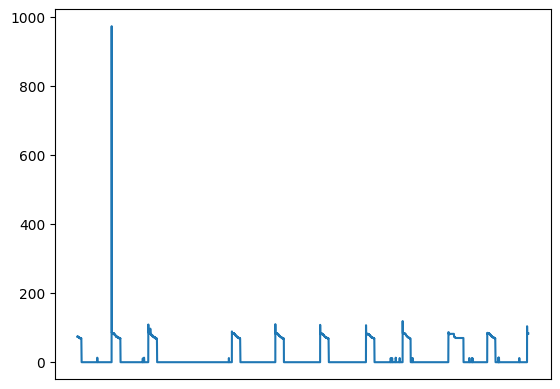

In [8]:
fig = plt.figure()
# ax = plt.axes()

x = df_prime["Time"][:DAY_WINDOW]
y = df_prime["Fridge"][:DAY_WINDOW]
plt.plot(x, y);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))  # Set major ticks every 1000 units
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(100))  # Set minor ticks every 100 units

plt.show()

First we will implement the cycle detection algorithm. We will trial with both the KNN and GMM algorithms.

For this we define a CycleDetection class, which can be initialized using the dataframe object, the name of the device, and the model you want to use to classify the datapoints using.
Essentially, the objective of this class is to construct a cluster algorithm for each class of device.

#### Cycle Detection Class usage guide

1. Initialization:

    df - the data frame which we want to train on.
    n_clusters - defines the number of clusters we want. default = 2
    device - the name of the device, for which you want to detect cycles.
    model - either "knn" or "gmm". User needs to pass in this parameter

2. KMeansTraining()

    Function will return a dataframe, and also dump it into a csv file.

3. detect_on_off(self, datapoint)
    
    Function takes in a single datapoint and tells you if it is part of
    an on cycle or an off cycle.

4. bulk_detect_on_off(self, data)
    
    Function to detect if a group of points "data" is on or off individually.
    
5. evaluation(self, ground_truth, test_data, metric = "acc"):
    
    Function to evaluate the trained dataset against the test data set, according the metric
    provided in the argument.

    ground_truth - dataframe object that represents the ground truth
    metric -  can be one of the following:
              1. "acc" - accuracy
              2. "prec" - precision
              3. "f1" - f1 score
    

In [115]:
class CycleDetection:

  def __init__(self, df, device, model, mode, s3_obj, n_clusters = 2):
    '''
    df - the data frame which we want to train on.
    n_clusters - defines the number of clusters we want.
    device - the name of the device, for which you want to detect cycles.
    model - either "knn" or "gmm". User needs to pass in this parameter
    mode - "test" or "train"
    '''
    self.n_clusters = n_clusters
    self.df = df
    self.device = device
    self.mode = mode
    self.s3 = s3_obj
    if model == "knn":
      self.model = KMeans(n_clusters= self.n_clusters, random_state=0) # Two states of the device: ON cycle and OFF cycle
    elif model!="knn" or model!="gmm":
      raise ValueError("The value passed in for the value paramter is incorrect")

  def KMeansTraining(self):
    '''
    Function will return a dataframe, and also dump it into a csv file.
    '''

    # Data frame creation
    self.df['Power Cycle'] = self.model.fit_predict(self.df[[self.device]]) # Add a new column called power cycle. This becomes z_k

    cluster_on = self.df.groupby('Power Cycle')[self.device].mean().idxmax()

    # Uncomment the line below, if ON or OFF output is preferred to 1s and 0s.
    # self.df['Power Cycle'] = self.df['Power Cycle'].map({cluster_on: 'ON', 1 - cluster_on: 'OFF'})

    # Data dump into csv file.
    target_directory = f"training/refrigerator/House_1_{self.device}_{self.mode}_labelled.csv"

    '''
    Data will be put into a file with the following format:
    "./drive/MyDrive/Datasets/House_1_{self.device}_labelled.csv"
    '''
    with io.StringIO() as csv_buffer:
      self.df.to_csv(csv_buffer, index=False)

      response = self.s3.put_object(Bucket=AWS_S3_BUCKET, Key=target_directory, Body=csv_buffer.getvalue())

      status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

      if status == 200:
          print(f"Successful S3 put_object response. Status - {status}")
      else:
          print(f"Unsuccessful S3 put_object response. Status - {status}")
      print(f"File saved to {target_directory}")
    return self.df

  def detect_on_off(self, datapoint):
    '''
    Function takes in a single datapoint and tells you if it is part of
    an on cycle or an off cycle.
    '''
    # Use the KMeans model to predict the cluster for the single data point
    power_cycle = self.model.predict(datapoint)[0]

    # Determine the cluster representing ON and OFF states
    cluster_on = self.df.groupby('Power Cycle')[self.device].mean().idxmax()

    # Map the cluster label to 'ON' or 'OFF'
    # power_cycle_label = 'ON' if power_cycle == cluster_on else 'OFF'
    return power_cycle #, power_cycle_label

  def bulk_detect_on_off(self, data):
    '''
    Function to detect if a group of points "data" is on or off individually.
    '''
    return self.model.predict(data[[self.device]])

  def evaluation(self, ground_truth, test_data, metric = "acc"):
    '''
    Function to evaluate the trained dataset against the test data set, according the metric
    provided in the argument.

    ground_truth - dataframe object that represents the ground truth
    metric -  can be one of the following:
              1. "acc" - accuracy
              2. "prec" - precision
              3. "f1" - f1 score
    '''

    #Step 1: Calculate the predicted values first
    predicted_values = self.bulk_detect_on_off(test_data)
    print(type(predicted_values), type(ground_truth))

    print(f"Ground truth values: {ground_truth}\n")
    print(f"Obtained predicted values: {predicted_values}\nComputing {metric} metric now...")

    match metric:
      case "acc":
        return metrics.accuracy_score(y_true = list(ground_truth), y_pred = list(predicted_values))
      case "prec":
        return metrics.precision_score(y_true = list(ground_truth), y_pred = list(predicted_values))
      case "f1":
        return metrics.f1_score(y_true = list(ground_truth), y_pred = list(predicted_values))
      case _:
        raise ValueError('''
              Provide a valid metric:\n
              \t1. "acc" - accuracy\n
              \t2. "prec" - precision\n
              \t3. "f1" - f1 score"\n
            '''
            )

## Evaluation for KNN and GMM

For the evaluation, we are making use of the following method:
1. First we split the training and the test data set into 80-20 split.
2. The training data and the test data are **both trained** seperately.
3. The test data predictions are checked against the predictions made by the bulk of the dataset. We achieve this comparison using the CycleDetection.evaluation method.

The purpose of an evaluation in this format is to help understand if a model constructed by the majority of the data is able to predict correctly.

#### Split and training

In [11]:
df_train, df_test = train_test_split(df_prime, test_size=0.2)

# Main model training
df_trained = CycleDetection(df_train, device = "Fridge", mode = "train", model = "knn")
training = df_trained.KMeansTraining()
print(training["Power Cycle"])


# # Ground truth training
# ground_truth = CycleDetection(df_test, device = "Fridge", mode = "test", model = "knn")
# ground_training = ground_truth.KMeansTraining()
# print(ground_training["Power Cycle"])



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


File saved to ./drive/MyDrive/Datasets/House_1_Fridge_train_labelled.csv
708346     0
5443934    0
1606171    0
674838     1
2098795    0
          ..
3155141    1
143638     0
427549     0
6725822    0
928801     1
Name: Power Cycle, Length: 5568006, dtype: int32


In [12]:
df_trained.detect_on_off([[38]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


0

In [13]:


gt_values = ground_training["Power Cycle"]


# Evaluation metric 1: Accuracy
acc = df_trained.evaluation(gt_values, df_test, "acc")
print("{:.10f}".format(acc) )

# Evaluation metric 2: Precision
prec = df_trained.evaluation(gt_values, df_test, "prec")
print("{:.10f}".format(prec) )

# Evaluation metric 3: F1 Score
f1 = df_trained.evaluation(gt_values, df_test, "f1")
print("{:.10f}".format(f1) )

NameError: name 'ground_training' is not defined

The evaluation method might be flawed, as all the metrics are 0. One interpretation of these results could be that the training for the ground truth values yielded a near 100% different clustering.

# Gaussian Calculator Class

This class will help calculate the pdf value, and also check a datapoint against the three sigma rule.


In [116]:
class GaussianCalculator:

  def __init__(self, data):
    self._mean = self.mean(data)
    self._stdev = self.stdev(data, xbar = self._mean)
    print(f"Mean: {self._mean}\nStdev: {self._stdev}")
    self._pdf = 0

  def calculate_pdf(self, datapoint):
    '''
    Datapoint here refers to the average power of last cycle.
    '''
    self._pdf = NormalDist(self._mean, self._stdev).pdf(datapoint)

  def update(self, data):
    self._mean = self.mean(data)
    self._stdev = self.stdev(data, xbar = self._mean)

  def mean(self, data):
    return mean(data)

  def stdev(self, data, xbar = None):
    return stdev(data, xbar = xbar)

  def sigma_rule(self):
    if self._pdf > (self._mean + (3*self._stdev)) or self._pdf < (self._mean - (3*self._stdev)):
      return True
    else:
      return False

# Data orchestrator

This section will focus on the following process:

1. Taking in the datapoint
2. Calling CycleDetection.detect_on_off
3. Putting data point into power array
4. Checking for anomaly

This relies on the following environment variables:

1. ***TARGET_TRAINING_SET*** - this is a file path along for a csv file. **Ensure TARGET_TRAINING_SET only has normal operation only.**
2. ***DEVICE*** - specific device for which we are carrying out the training.

The initialization of the class involves two arguments:

1. `device` - for which the Orchestration is happening
2. `device_mapping` - using which the dataframe can be read

In [117]:
# Only for
from random import randrange

In [119]:
class Orchestrator:
  '''
    Function to orchestrate the whole process from start to finish.

    This relies on the following environment variables:
    1. TARGET_TRAINING_SET - this is a file path along for a csv file. ENSURE THAT TARGET_TRAINING_SET only has normal operation only.
    2. DEVICE - specific device for which we are carrying out the training.
  '''

  def __init__(self, device, device_mapping):

    print("Reading CSV file")
    start = time()
    self.s3 = boto3.client('s3', aws_access_key_id = AWS_ACCESS_KEY_ID, aws_secret_access_key = AWS_SECRET_ACCESS_KEY, aws_session_token=AWS_SESSION_TOKEN)
    response = self.s3.list_buckets()
    print("Bucket list:", response["Buckets"])

    response = self.s3.get_object(Bucket=AWS_S3_BUCKET, Key=TARGET_TRAINING_SET)

    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 get_object response. Status - {status}")
        self.df = pd.read_csv(response.get("Body"))
    else:
        print(f"Unsuccessful S3 get_object response. Status - {status}")
        exit(-1)



    # self.df = pd.read_csv(TARGET_TRAINING_SET)
    print("Renaming...")
    self.df = self.df.rename(index=str, columns=device_mapping)
    print(f"Time taken: {time() - start}")

    # Cycle detection and count helpers
    print("Initializing Cycle Detector")
    start = time()
    self.cycle_detector = CycleDetection(df = self.df, device = device, model = "knn", mode = "train", s3_obj = self.s3)
    print(f"Time taken: {time() - start}")

    self.current_cycle = -1
    self.previous_cycle = -1

    self.current_power_list = []

    # Gaussian Detection
    self.normal_operation = self.df[device].tolist()
    self.gauss = GaussianCalculator(data = self.normal_operation)

  def run(self):
    # First train on the data made available for training.
    print(f"Training cycle detector")
    start = time()
    self.cycle_detector.KMeansTraining()
    print(f"Time taken: {time() - start}")

    # Continuously request for datapoint from an endpoint and check to see if it is anomalous or not
    while(True):
      sleep(3)
      datapoint = self.receive() # THIS METHOD IS YET TO BE IMPLEMENTED BASED ON AWS DATA STREAMING
      print(f"\n\nReceived Datapoint {datapoint}")
      self.current_cycle = self.cycle_detector.detect_on_off([[datapoint]]) # Outputs 0 or 1 for OFF or ON respectively
      print(f"Datapoint classified as {'ON' if self.current_cycle else 'OFF'}")

      if self.previous_cycle == -1 or self.previous_cycle == self.current_cycle:
        # If the previous cycle is uninitialized or if the current and previous datapoints belong to the same cycle
        print("Same as previous cycle")
        self.previous_cycle = self.current_cycle
        self.current_power_list.append(datapoint)

      if self.current_cycle != self.previous_cycle:
        if len(self.current_power_list) < 2:
          # The minimum number of datapoints to qualify as a cycle is 2. However, in the rare scenario that the power cycle keeps oscillating
          # between ON and OFF before accumulating atleast 2 datapoints in each cycle, we can continue the loop and set the current cycle to the
          # same as the previous cycle. This effectively accumulates atleast two datapoints in current power list, even if the power cycle is erratic
          # and jumps around.
          self.current_power_list.append(datapoint)
          self.previous_cycle = self.current_cycle
          continue

        print("Different from previous cycle")
        # The cycle has changed, and it's time to check if the cycle is anomalous or not.
        # Step 1: Calculate the average power in the current cycle (Done by the Gauss class, internally)
        # Step 2: Plug this into gaussian pdf formula (Need to trigger pdf function of Gauss)
        # Step 3: Evaluate to see if you need to raise alarm (Need to carry out check in this function)

        average_power = mean(self.current_power_list)
        self.gauss.calculate_pdf(average_power)
        alarm = self.gauss.sigma_rule()
        if alarm:
          print(f"ANOMALOUS CYCLE | Datapoint: {average_power}")
        else:
          print(f"NORMAL CYCLE | Datapoint: {average_power}")
          # Call update here using self.normal_operation


        self.current_power_list = []
        self.current_power_list.append(datapoint)
        self.previous_cycle = self.current_cycle
  def receive(self):
    '''
      Function to ping endpoint and see if there is any datapoint available
    '''

    return randrange(0, 150, 5)

In [120]:
main = Orchestrator(device = DEVICE, device_mapping = DEVICE_MAPPING)

Reading CSV file
Bucket list: [{'Name': 'kit-app-ref', 'CreationDate': datetime.datetime(2024, 3, 7, 12, 37, tzinfo=tzlocal())}, {'Name': 'reinvent2020-anomaly-iteration-processeddatabucket-a5nbl0jenh0p', 'CreationDate': datetime.datetime(2024, 2, 19, 16, 41, 10, tzinfo=tzlocal())}, {'Name': 'reinvent2020-anomaly-iteration-v3-ingestdatabucket-suhtbdas1lph', 'CreationDate': datetime.datetime(2024, 2, 19, 16, 41, 11, tzinfo=tzlocal())}, {'Name': 'reinvent2020-anomaly-iteration-v3-predi-logsbucket-5npsb8z9etji', 'CreationDate': datetime.datetime(2024, 2, 19, 16, 40, 39, tzinfo=tzlocal())}, {'Name': 'reinvent2020-anomaly-prediction-730335507769-us-east-1-dev', 'CreationDate': datetime.datetime(2024, 2, 19, 16, 39, 53, tzinfo=tzlocal())}, {'Name': 'sagemaker-us-east-1-730335507769', 'CreationDate': datetime.datetime(2024, 2, 19, 17, 32, 55, tzinfo=tzlocal())}]
Successful S3 get_object response. Status - 200
Renaming...
Time taken: 20.79420518875122
Initializing Cycle Detector
Time taken: 6.

In [121]:
import warnings
warnings.filterwarnings(action='ignore')

main.run()

Training cycle detector
Successful S3 put_object response. Status - 200
File saved to training/refrigerator/House_1_Fridge_train_labelled.csv
Time taken: 40.98443579673767


Received Datapoint 130
Datapoint classified as ON
Same as previous cycle


Received Datapoint 115
Datapoint classified as ON
Same as previous cycle


Received Datapoint 45
Datapoint classified as ON
Same as previous cycle


Received Datapoint 120
Datapoint classified as ON
Same as previous cycle


Received Datapoint 75
Datapoint classified as ON
Same as previous cycle


Received Datapoint 70
Datapoint classified as ON
Same as previous cycle


Received Datapoint 45
Datapoint classified as ON
Same as previous cycle


Received Datapoint 60
Datapoint classified as ON
Same as previous cycle


Received Datapoint 25
Datapoint classified as OFF
Different from previous cycle
NORMAL CYCLE | Datapoint: 82.5


Received Datapoint 50
Datapoint classified as ON


KeyboardInterrupt: 